In [ ]:
!pip install lpips

In [1]:
# %% Import and stuff

import torch
from torch import nn
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import time
import random
import torchvision.utils as vutils
from  torch.utils import data
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.colors as mcolors
import os
import gc
import math
from collections import OrderedDict
from torch.utils.data import Subset
from datetime import datetime 
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as tran
from scipy import linalg
import lpips

from scipy.stats import entropy




NUM_EPOCHS = 60
LR = 0.0008
LATENT_SPACE_SIZE = 20
IMG_SIZE = 28
CHANNELS = 1
B1 = 0.5
B2 = 0.999
RANDOM_SEED = 123


STATE_DICT = "state_dict"
MODEL_OPTIMIZER = "model_optimizer"
LOSSES = "losses"
RECON_LOSS = "recon_loss"
KL_DIV = "kl_div"

SHUFFLE = True
PIN_MEMORY = True
NUM_WORKERS = 0
BATCH_SIZE = 2000

specific_latent = torch.tensor([[0.7628, 0.1779, 0.3978, 0.3606, 0.6387,
         0.3044, 0.8340, 0.3884, 0.9313, 0.5635, 0.1994, 0.6934, 0.5326,
         0.3676, 0.5342, 0.9480, 0.4120, 0.5845, 0.4035, 0.5298, 0.0177,
         0.5605, 0.6453, 0.9576, 0.7153, 0.1923, 0.8122, 0.0937, 0.5744,
         0.5951, 0.8890, 0.4838, 0.5707, 0.6760, 0.3738, 0.2796, 0.1549,
         0.8220, 0.2800, 0.4051, 0.2553, 0.1831, 0.0046, 0.9021, 0.0264,
         0.2327, 0.8261, 0.0534, 0.1582, 0.4087, 0.9047, 0.1409, 0.6864,
         0.1439, 0.3432, 0.1072, 0.5907, 0.6756, 0.6942, 0.6814, 0.3368,
         0.4138, 0.8030, 0.7024, 0.3309, 0.7288, 0.2193, 0.1954, 0.9948,
         0.1201, 0.9483, 0.7407, 0.4849, 0.6500, 0.8649, 0.7405, 0.4725,
         0.5373, 0.6541, 0.5444, 0.7425, 0.8940, 0.3580, 0.3905, 0.8924,
         0.2995, 0.3726, 0.5399, 0.3057, 0.3380, 0.8313, 0.1137, 0.0120,
         0.7714, 0.2561, 0.2569, 0.2994, 0.7648, 0.2413, 0.6101
        ]])


img_shape = (CHANNELS, IMG_SIZE, IMG_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:{}'.format(device))

Device:cuda


In [2]:
 # %%helper functions

def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)

def plot():
    for i,(image, _) in example_loader:
        f, axarr = plt.subplots(2)
    
        # Reshape the array for plotting
        axarr[0].imshow(image[0].to(device))
    

        result = model.decoder(torch.tensor([-0.0,0.03]).to(device))
        result = result.squeeze(0)
        result = result.squeeze(0)
        axarr[1].imshow(result[0].to('cpu').numpy())
                  
def add_noise(inputs,variance):
    noise = torch.randn_like(inputs)
    return inputs + variance*noise


def save_checkpoint(state, filename):
    print("=> Saving chekpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint):
    model.load_state_dict(checkpoint[STATE_DICT])
    optimizer.load_state_dict(checkpoint[MODEL_OPTIMIZER])
    #losses = checkpoint[LOSSES]
    #recon_losses = checkpoint[RECON_LOSS]
    #l_losses = checkpoint[KL_DIV]
    #return losses, kl_losses, recon_losses
    
    
def get_numbered_images():  
    numberred_images = []
    
    for batch_idx, (images, labels) in enumerate(train_loader):
        for i in range(len(labels[:])):
            if batch_idx == labels[i].item():
                numberred_images.append(images[i])
                break          
    
    return numberred_images
          

def plot_generated_images(c, figsize=(20, 2.5), n_images=10):
    model.to(device)
    c = torch.tensor(c, dtype=torch.int64).to(device)

    fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                             sharex=True, sharey=True, figsize=figsize)
    
    for batch_idx, (images, _) in enumerate(train_loader):
        
        images = images.to(device)
        with torch.no_grad():
           encoded, z_mean, z_log_var, decoded_images = model(images,c)[:n_images]

        orig_images = images[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            ax[i].imshow(curr_img.view((28, 28)))
            
            
def plot_numberred_images(numbered_images,figsize=(20, 2.5)):

    with torch.no_grad(): 
        fig, axes = plt.subplots(nrows=2, ncols=10, 
                                 sharex=True, sharey=True, figsize=(20, 2.5))

        for i in range(10):
            latent = torch.rand_like(torch.Tensor(20)).to(device)
            c = torch.tensor(i, dtype=torch.int64).to(device) 
            
            gen_img = model.decoder(latent,c).detach().to(torch.device('cpu'))
            axes[0][i].imshow(numbered_images[i].view((28, 28))) 
            axes[1][i].imshow(gen_img.view((28, 28)))
        
        plt.figure().clear()
            
def gen_image(c=-1):
    with torch.no_grad():
        if c == -1:
          c = random.randint(0, 9)

        fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)

        c = torch.tensor(c, dtype=torch.int64).to(device)
        latent = torch.rand_like(torch.Tensor(20)).to(device)

        decoded = model.decoder(latent,c).cpu()
        print('supposed to be ',c.item())
        axes.imshow(decoded.view((28, 28)))   
        
#plot a grid of r,c images,reccomended with 10,10
def plot_many_images(r=10,c=10):
    fig, axes = plt.subplots(nrows=r, ncols=c,figsize=(20, 20), sharex=True, sharey=True)
    
    for i in range(r):
        for y in range(c):
            caption = torch.tensor(y, dtype=torch.int64).to(device)
            latent = torch.rand_like(torch.Tensor(LATENT_SPACE_SIZE)).to(device)
    
            decoded = model.decoder(latent,caption).detach().to(torch.device('cpu'))
            axes[i][y].imshow(decoded.view((28, 28)))   
    
    plt.figure().clear()


def plot_latent_space_with_labels(iteration, num_classes=10):
    d = {i:[] for i in range(num_classes)}

    with torch.no_grad():
        for i, (features, targets) in enumerate(train_loader):

            features = features.to(device)
            targets = targets.to(device)
            
            embedding = model.encoding_fn(features)

            for i in range(num_classes):
                if i in targets:
                    mask = targets == i
                    d[i].append(embedding[mask].to('cpu').numpy())

    colors = list(mcolors.TABLEAU_COLORS.items())
    for i in range(num_classes):
        d[i] = np.concatenate(d[i])
        plt.scatter(
            d[i][:, 0], d[i][:, 1],
            #color=colors[i][1],
            #label=f'{i}',
            alpha=0.5)


    plt.figure().clear()


def plot_losses():
    plt.figure(figsize=(10, 5))
    plt.title("Loss During Training")
    plt.plot(losses[:], label="L")
    plt.plot(kl_losses[:], label="KL")
    plt.plot(recon_losses[:], label="Recon")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    
    plt.figure().clear()
    
def clear_cache():
    torch.cuda.empty_cache()
    gc.collect()
    


def showExample():
  for image, _ in example_loader:
      f, axarr = plt.subplots(2)
      image = image.reshape(-1,28*28).to(device)

      model.to(device)
      recon = model(image)

      image = image.reshape(-1, 28, 28)
      axarr[0].imshow(image[0].cpu())


      recon = recon.reshape(-1, 28, 28).to('cpu')
      axarr[1].imshow(recon[0].detach().numpy())

      break        
def colorize(image):
  return torch.cat([image, image, image], dim=1)

In [3]:
# %%Train Data

set_deterministic
set_all_seeds(RANDOM_SEED)

transform = transforms.Compose([
    transforms.ToTensor()])


train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = data.DataLoader(
                                train_dataset,
                                batch_size=BATCH_SIZE,
                                shuffle=SHUFFLE,
                                num_workers=NUM_WORKERS,
                                pin_memory=PIN_MEMORY,
                                drop_last=False
                                )

test_loader = data.DataLoader(
                                test_dataset,
                                batch_size=32,
                                shuffle=True,
                                num_workers=0
                                )

example_loader = data.DataLoader(
                                train_dataset,
                                batch_size=1,
                                shuffle=True,
                                num_workers=0,
                                drop_last=True
                                 )


In [4]:
# %%Model

class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
           
        self.z_mean = torch.nn.Linear(3136, LATENT_SPACE_SIZE) # 2 dim for visualization purposes
        self.z_log_var = torch.nn.Linear(3136, LATENT_SPACE_SIZE)
        
        self.d_emb = nn.Embedding(10, 50)
        self.e_emb_fc = nn.Linear(50, 784)
        self.d_emb_fc = nn.Linear(50, 49)
       
        #########
        # Encoder
        #########
        self.e_conv1 = nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1)
        self.e_conv2 = nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1)
        self.e_conv3 = nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1)
        self.e_conv4 = nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1)
        self.flatten = nn.Flatten()
        

        #########
        # Decoder
        #########  
        self.d_lin = torch.nn.Linear(LATENT_SPACE_SIZE, 3087)
        self.d_conv1 = nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1)
        self.d_conv2 = nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1)              
        self.d_conv3 = nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0)              
        self.d_conv4 = nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0)
       
        
    def encoder(self, x, c):
        #c = self.d_emb(c)
        #c = self.e_emb_fc(c)
        #c = c.view(-1, 1, 28, 28)
        #x = torch.cat((x, c), 1)

        x = F.leaky_relu(self.e_conv1(x))
        x = F.leaky_relu(self.e_conv2(x))
        x = F.leaky_relu(self.e_conv3(x))
        x = self.e_conv4(x)
        x = self.flatten(x)
        x = x.reshape(-1)
        return x
    
    
    def decoder(self, x, c):
        c = self.d_emb(c)
        c = self.d_emb_fc(c)
        c = c.view(-1, 1, 7, 7)
        
        x = self.d_lin(x)
        x = x.view(-1, 63, 7, 7)
        
        x = torch.cat((c, x), 1)
        
        x = x.view(-1,64,7,7)
        x = F.leaky_relu(self.d_conv1(x))
        x = F.leaky_relu(self.d_conv2(x))
        x = F.leaky_relu(self.d_conv3(x))
        x = F.leaky_relu(self.d_conv4(x))
        x = x[:, :, :28, :28]
        x = torch.sigmoid(x)
        return x
    
    def encoding_fn(self, x, c):
        x = self.encoder(x, c)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparam(self,mu,log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std)
        z = mu+ eps*std

    def reparameterize(self, z_mu, z_log_var):
        std = torch.exp(0.5*z_log_var)
        eps = torch.rand_like(std).to(device)
        z = z_mu + eps * std
        return z
        
    def forward(self, x, c):
        x = self.encoder(x, c)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var) # sample μ,σ to create distribution
        decoded = self.decoder(encoded,c)
        return encoded, z_mean, z_log_var, decoded
 

 

In [5]:
# %% Instantiate model, loss func, optimizer

model = VAE()
 
# Validation using MSE Loss function
loss_function = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(B1 ,B2))

if torch.cuda.is_available():
    model = model.cuda()
    loss_function = loss_function.cuda()



In [ ]:
# %%Train Model

if torch.cuda.is_available():
    model = model.to(memory_format=torch.channels_last)
    loss_function.to(device)
    model.train()
    torch.backends.cudnn.benchmark = True
  

logging_interval = 10
losses = []
kl_losses = []
recon_losses = []
recon_loss = 0
kl_div = 0
iter = 0
alpha = 1


    
for epoch in range(4):
    #st = time.time()
    for batch, (imgs, labels) in enumerate(train_loader):

        imgs = imgs.to(device,memory_format=torch.channels_last)
        labels = labels.to(device)

        # set gradients to zero
        optimizer.zero_grad()
        encoded, z_mean, z_log_var, decoded = model(imgs,labels)
        print("imgs: ",imgs.shape)
        print("labels: ",labels.shape)
        break

        # Total Loss = Recon_loss + KLDivergence
        kl_div = -0.5 * torch.sum(1 + z_log_var 
                                  - z_mean**2 
                                  - torch.exp(z_log_var), 
                                  axis=1) # sum over latent dimension

        kl_div = kl_div.mean()

        recon_loss = loss_function(decoded, imgs)
        recon_loss = recon_loss.view(BATCH_SIZE, -1).sum(axis=1) # sum over pixels
        recon_loss = recon_loss.mean() # average over batch dimension
        
        loss = alpha*recon_loss + kl_div
        loss.backward()
        optimizer.step()  # Updates Weights
        
        loss_item = loss.item()
        recon_loss_item = recon_loss.item()
        kl_div_item = kl_div.item()
        
        #scheduler.step()
        
        
        if iter % logging_interval == 0:
            print('[%d/%d][%d/%d]\t, LOSS:%.4f (recon_loss : %.4f, kl_loss = %.6f'
                  %(epoch, NUM_EPOCHS, batch, len(train_loader), loss_item, recon_loss_item, kl_div_item))
        
        
        losses.append(loss_item)
        kl_losses.append(kl_div_item)
        recon_losses.append(recon_loss_item)
        
        iter +=1


In [ ]:
# %% Save Model
checkpoint = {STATE_DICT : model.state_dict(),
              MODEL_OPTIMIZER : optimizer.state_dict(),
              LOSSES: losses,
              RECON_LOSS:recon_losses,
              KL_DIV:kl_losses}
save_checkpoint(checkpoint, "cVAE4.pth.tar")

In [6]:
# %%  Load Model
load_checkpoint(torch.load("..\checkpoint_files\cVAE4.pth.tar",map_location=(device)))

supposed to be  0


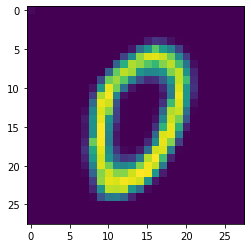

In [7]:
#Test image generation
gen_image()

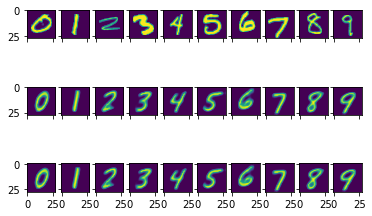

In [8]:
# %% print reconstructed image vs generated image vs actual images
if 'numbered_images' not in locals():
    numbered_images = get_numbered_images()

torch.device = device
model = model.to(device)
fig, axes = plt.subplots(nrows=3, ncols=10, sharex=True, sharey=True)
with torch.no_grad():
  for i in range(10):
    
    #for batch_idx, (images, labels) in enumerate(example_loader):
    
    c = torch.tensor(i, dtype=torch.int64).to(device)
    latent = torch.rand_like(torch.Tensor(20)).to(device)
    img = numbered_images[i].to(device)
  

    
    decoded = model.decoder(latent,c).detach().cpu()
    #recon = model()
    
    #image from dataset
    axes[0][i].imshow(numbered_images[c.item()][None, :].view((28, 28)))   
    
    #image from decoder, caption
    axes[1][i].imshow(decoded.view((28, 28)))  

    #reconstructed_image
    x = model(img, c)[3]
    axes[2][i].imshow(decoded.view((28, 28)))  

In [9]:
#Generate batch of fake and real samples 
fake_images = []
real_images = []
device='cpu'
with torch.no_grad():
    model.to('cpu')

    for i, (imgs,label) in enumerate(train_loader):
        real_images = imgs
        
        #caption = random.randint(0, 9)   
        #caption = torch.tensor(caption, dtype=torch.int64)
        #latent = torch.rand_like(torch.Tensor(1,100))
        #fake_images = generator(latent,caption)
        
        
        for i in range(len(real_images[:])):
          caption = label[i]
          latent = torch.rand_like(torch.Tensor(1,LATENT_SPACE_SIZE))
          fake_image = model.decoder(latent,caption)

          if (i==0):
            fake_images = model.decoder(latent,caption)
          else:
            fake_images = torch.cat((fake_images, fake_image), 0)
        break

print('Generated %d samples'
%(len(fake_images[:])))
#fake_images

Generated 2000 samples


In [10]:
#LPIPS metric 
loss_fn_alex = lpips.LPIPS(net='alex') 

lpip_fake = colorize(fake_images)
lpip_real = colorize(real_images) # !! images must be rbg and within [-1,1]

lpip_fake = transforms.Compose([
    transforms.Resize((64, 64))])(lpip_fake)

lpip_real = transforms.Compose([
    transforms.Resize((64, 64))])(lpip_real)



d = loss_fn_alex(lpip_fake, lpip_real)
print("LPIPS score %.4f"%(d[0].item()))

my_tensor = d

# get minimum value
min_val = torch.min(my_tensor)

# get maximum value
max_val = torch.max(my_tensor)

# get mean value
mean_val = torch.mean(my_tensor)

# print the results
print("Minimum score: %.4f" %(min_val.item()))
print("Maximum score: %.4f" %(max_val.item()))
print("Mean score: %.4f" %(mean_val.item()))

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: D:\Anaconda\envs\pytorch\lib\site-packages\lpips\weights\v0.1\alex.pth
LPIPS score 0.1674
Minimum score: 0.0524
Maximum score: 0.5425
Mean score: 0.1820


In [ ]:
#idea from here: https://liorsinai.github.io/coding/2022/12/29/denoising-diffusion-2-unet.html#mjx-eqn-eqFrechet
#Calculate mean of real images
random.seed(42)
mnist_mean = []
mnist_means = []
samples = 1000

# convert dataset to numpy array
test_array = np.array([(np.array(x), y) for x, y in test_loader.dataset])
# for each number(0,9)
for num in range(10):
  # get indices of images with the current number
  indices = np.where(test_array[:, 1] == num)[0]
  # randomly sample max number of images
  subset_indices = random.sample(indices.tolist(), samples) if len(indices) > samples else indices
  subset_array = test_array[subset_indices]

  # compute mean of sampled images using numpy
  number_mean = np.mean(subset_array[:, 0], axis=0)

  mnist_means.append(torch.from_numpy(number_mean))
  

mnist_mean = (torch.stack(mnist_means, dim=0))

In [ ]:
#Create mean of generated images

num_samples = 1000
fake_images_means = []
fake_image_mean = []

distances = []
with torch.no_grad():
  for num in range(10):
    for i in range(num_samples):
      latent = torch.rand_like(torch.Tensor(1,LATENT_SPACE_SIZE))
      caption = torch.tensor(num, dtype=torch.int64)
      
      fake_image = model.decoder(latent,caption)  
      fake_image_mean.append(fake_image[0])
    
    fake_image_mean = torch.stack(fake_image_mean,dim=0)
    fake_image_mean = torch.mean(fake_image_mean, dim=0)

    fake_images_means.append(fake_image_mean)
    fake_image_mean = []  

fake_images_means = torch.stack(fake_images_means,dim=0)

In [ ]:
#Mean of generated vs actual images
fig, axes = plt.subplots(nrows=2,ncols=10,figsize=(20,2.5))
plt.tick_params(labelsize=0)


for i in range(len(mnist_mean[:])):
  axes[1][i].imshow(mnist_mean[i][0])
for i in range(len(fake_images_means[:])):
  axes[0][i].imshow(fake_images_means[i][0])

In [ ]:
#calculate distances
#distances = [[0] * len(mnist_mean) for _ in range(10)]
distances = []

for i in range(len(fake_images_means[:])):

  diff = mnist_mean[i] - fake_images_means[i]
  distance = torch.norm(diff, p=2)
  
  distances.append(distance.item())
 
  print('Number: %d, Distance: %.4f'
  %(i,distance.item()))

# Print the distance
print("Mean distance: %.4f"%
      (sum(distances)/len(distances)))

In [ ]:
fig, ax = plt.subplots(figsize=[10,6])

ax.bar(range(len(distances)), distances)

ax.set_xlabel('Image')
ax.set_ylabel('Distance')
ax.set_title('Distance per image')

ax.set_xticks(range(len(distances)))
ax.set_xticklabels(range(len(distances)))

plt.show()

In [ ]:
#model from here: https://github.com/erykml/medium_articles/blob/master/Computer%20Vision/lenet5_pytorch.ipynb
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
LEARNING_RATE = 0.001
N_CLASSES = 10

model = LeNet5(N_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [ ]:
#Load checkpoint
leNet_load_checkpoint = torch.load('leNet_checkpoint.pth.tar')

model.load_state_dict(leNet_load_checkpoint['leNet_model_state_dict'])
optimizer.load_state_dict(leNet_load_checkpoint['leNet_optmizer_state_dict'])

In [ ]:
#Frechet LeNet Distance
def calculate_activation_statistics(images, model):
  with torch.no_grad():
    model.eval()
    activations = []
    
    features = model.feature_extractor(images)
    activations.append(features)
    
    activations = np.concatenate(activations, axis=0)
    mu = np.mean(activations, axis=0)

    activations = activations.reshape(activations.shape[0], -1)  # flatten the activations to 2D

    sigma = np.cov(activations, rowvar=False)
    return mu, sigma


def calculate_frechet_distance(mu1, cov1, mu2, cov2):
  eps = 1e-6
  diff = mu1 - mu2
  # Product of two covariance matrices
  cov_mean, _ = linalg.sqrtm(cov1.dot(cov2), disp=False)
  if not np.isfinite(cov_mean).all():
      offset = np.eye(cov1.shape[0]) * eps
      cov_mean = linalg.sqrtm((cov1 + offset).dot(cov2 + offset))
  # Compute the Wasserstein-2 distance
  return np.sum(diff ** 2) + np.trace(cov1 + cov2 - 2 * cov_mean)



# Generate fake data and compute statistics
resize = tran.Resize((32, 32))



fake_big = resize(fake_images)
real_big = resize(real_images)

mu1, cov1 = calculate_activation_statistics(fake_big, model)
mu2, cov2 = calculate_activation_statistics(real_big, model)
frechet_distance = calculate_frechet_distance(mu1, cov1, mu2, cov2)

print("Frechet_distance between real and generated images is: %.6f"
  %(frechet_distance))